In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error

from math import sqrt

from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
zipurl = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip'
with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall('/tmp/Bike-Sharing-Dataset')
        
bike_df_hour =  pd.read_csv('/tmp/Bike-Sharing-Dataset/hour.csv')
bike_df_day =  pd.read_csv('/tmp/Bike-Sharing-Dataset/day.csv')

In [2]:
bike_df_day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [3]:
bike_df_hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
bike_df_hour.cnt.describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

In [16]:
bike_df_hour.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

# Visualization

- plot scatter plots to see the relation between each attribute to the counts

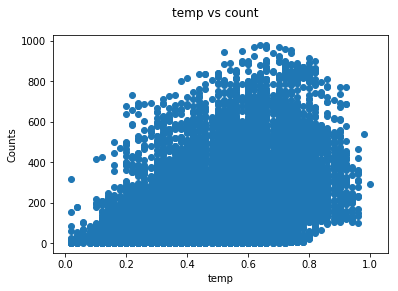

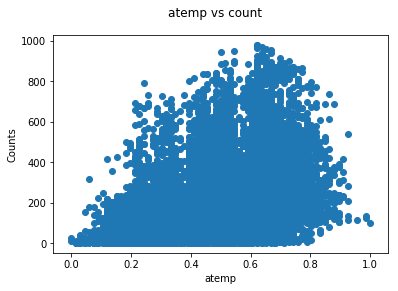

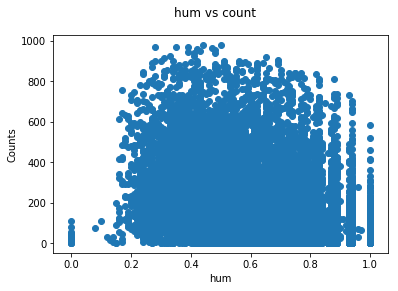

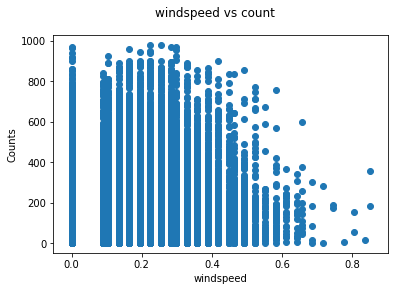

In [18]:
fig,ax = plt.subplots(1)
for col in bike_df_hour.columns:
    if bike_df_hour[col].dtypes=='float64':
        plt.scatter(bike_df_hour[col],bike_df_hour.cnt)
        plt.suptitle('{} vs count'.format(col))
        plt.xlabel(col)
        plt.ylabel('Counts')
        plt.show()
        

### windspeed has a negative correlation,
### atemp and temp have a positive correlation
### hum is not evidently significant, but low hum has low values

## Explore Categorical Features

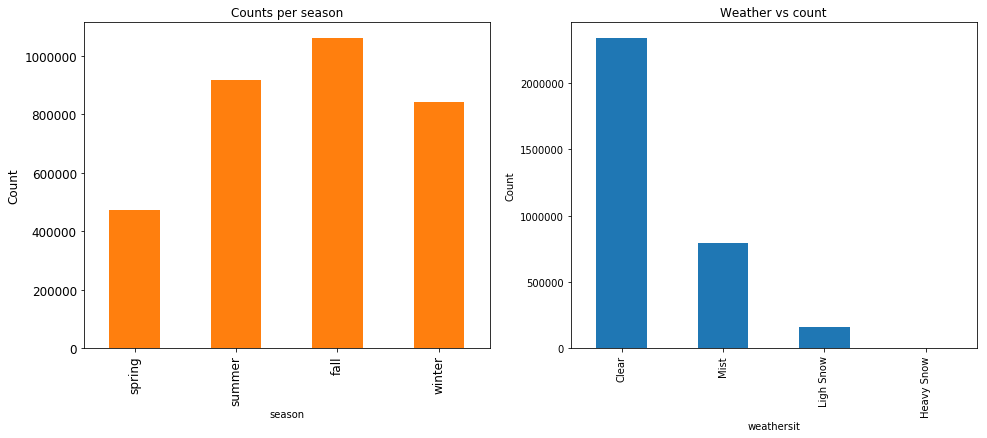

In [43]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2, figsize=(16,6))

ax1 =  bike_df_hour[['season','cnt']].groupby(['season']).sum().reset_index().plot(kind='bar',
                                                                                  legend = False,
                                                                                  title='Counts per season',
                                                                                  stacked=True,
                                                                                  fontsize=12,
                                                                                  ax=ax1)
ax1.set_ylabel('Count',fontsize=12)
ax1.set_xlabel('season')
ax1.set_xticklabels(['spring','summer','fall','winter'])

ax2 =  bike_df_hour[['weathersit','cnt']].groupby(['weathersit']).sum().plot(kind='bar',legend=False,
                                                                        title='Weather vs count',
                                                                        stacked=True,
                                                                        ax=ax2)
ax2.set_ylabel('Count')
ax2.set_xlabel('weathersit')
ax2.set_xticklabels(['Clear','Mist','Ligh Snow','Heavy Snow'])
fig.show()

Text(0.5, 0, 'Hours')

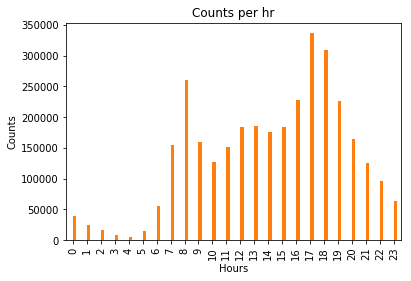

In [46]:
ax = bike_df_hour[['hr','cnt']].groupby(['hr']).sum().reset_index().plot(kind='bar',
                                                                        legend=False,
                                                                        title='Counts per hr',
                                                                        )
ax.set_ylabel('Counts')
ax.set_xlabel('Hours')


Text(0.5, 0, 'month')

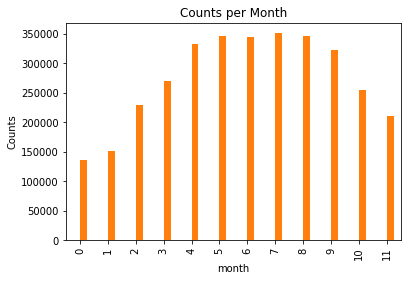

In [52]:
ax = bike_df_hour[['mnth','cnt']].groupby(['mnth']).sum().reset_index().plot(kind='bar',
                                                                        legend=False,
                                                                        title='Counts per Month',
                                                                        )
ax.set_ylabel('Counts')
ax.set_xlabel('month')


[Text(0, 0, '2011'), Text(0, 0, '2012')]

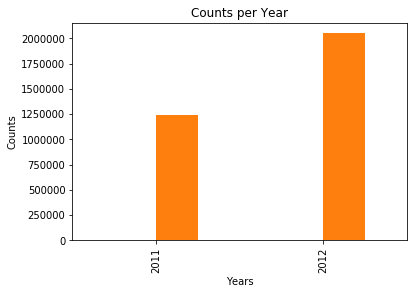

In [53]:
ax = bike_df_hour[['yr','cnt']].groupby(['yr']).sum().reset_index().plot(kind='bar',
                                                                        legend=False,
                                                                        title='Counts per Year',
                                                                        )
ax.set_ylabel('Counts')
ax.set_xlabel('Years')
ax.set_xticklabels([2011,2012])


### Mornng hours 8/9 and evening hours have the highest counts( in and out of work)
### mid year from April to Sept has consistently high values,
### 2012 has higher values probably due to rise in popularity and effectiveness of marketing strategies

# Regression Modeling
- y=ax+b, We ought to find the coefficient a and intercept b that gives the best predictions for our model
- we need to find the most influential features to use in our final model and optimize the predicting model
- Some features ought to be drop as they do not have an effect on the value counts such as the the instant (that is clearly not a feature). 
- Others result to multicollinearity. casual and registered when added result to the count, so they cannot be used as cnt is a function of the two
- atemp and temp are a function of each other so use one but not  both
### Categorizing features:
- Categoricals: weathersit, seasons, holiday, hour, month, year, weakday
- Numerical: temp, atemp,hum, windspeed

In [55]:
bike_df_hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [76]:
from sklearn.feature_selection import chi2,SelectKBest,f_regression
X = bike_df_hour[['season','yr','mnth','hr','holiday','weekday','workingday','weathersit','temp','hum','windspeed']]
y= bike_df_hour.cnt
X_selected = SelectKBest(f_regression,k=8)
X_selected.fit_transform(X,y)
col_sel = X.columns[X_selected.get_support()]

- SelectKBest gives yr,hr, temp and hum as the top 4 selections
- From our analysis, we can tell that the year is a weak predictor as we are dealing with an hourly data.

In [93]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state = 42)
from sklearn import linear_model
from sklearn.metrics import accuracy_score,r2_score
from sklearn.ensemble import GradientBoostingRegressor

for col in col_sel:
    clf =  linear_model.LinearRegression()
    clf.fit(x_train[[col]],y_train)
    pred = clf.predict(x_test[[col]])
    r2_ = r2_score(pred,y_test)
    meansq=sqrt(mean_squared_error(y_test,pred))
    print(col)
    print("Acc = {}".format(meansq))
    print("r = {}".format(r2_))
    
    

season
Acc = 171.9228764034059
r = -12.051317953141078
yr
Acc = 173.31184990012898
r = -12.284061509732735
mnth
Acc = 171.23328233105374
r = -10.440400682147207
hr
Acc = 126.88063351383171
r = 0.022761447778637756
weathersit
Acc = 176.09607499902916
r = -41.17085275224459
temp
Acc = 161.3238915626559
r = -3.618456612230357
hum
Acc = 167.30954667696244
r = -6.023598932990785
windspeed
Acc = 176.5796426500013
r = -59.06417825263831


## Dummify Categoricals

In [103]:
cat_cols =['season','yr','mnth','hr','holiday','weekday']
cat_df = pd.get_dummies(X,columns=cat_cols,
                       drop_first=True,
                       dummy_na=True)


,workingday,weathersit,temp,hum,windspeed,season_2.0,season_3.0,season_4.0,season_nan,yr_1.0,...,hr_nan,holiday_1.0,holiday_nan,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0,weekday_nan
0,0,1,0.24,0.81,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0.22,0.80,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,1,0.22,0.80,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0.24,0.75,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0.24,0.75,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## Linear Regression vs GBRegression

In [108]:
clf =  linear_model.LinearRegression()
x_train,x_test,y_train,y_test = train_test_split(cat_df,y,test_size=0.3, random_state = 42)
clf.fit(x_train,y_train)
pred =  clf.predict(x_test)
print("R^2 is {}".format(r2_score(pred,y_test)))
print("Mean Squared Error is {}".format(sqrt(mean_squared_error(pred,y_test))))

R^2 is 0.5294399164994201
Mean Squared Error is 100.91574841330872


In [110]:
clf = GradientBoostingRegressor()
clf.fit(x_train,y_train)
pred =  clf.predict(x_test)
print("R^2 is {}".format(r2_score(pred,y_test)))
print("Mean Squared Error is {}".format(sqrt(mean_squared_error(pred,y_test))))

R^2 is 0.6651072498745145
Mean Squared Error is 79.35061992668012


## Simplistic Model for the App

In [149]:
X= bike_df_hour[['season','temp','hr','holiday']]
y_ready=bike_df_hour.cnt
X_ready =  pd.get_dummies(X,columns=['season'])
x_train,x_test,y_train,y_test = train_test_split(X_ready,y_ready,test_size=0.3, random_state = 42)
x_train.head()

,temp,hr,holiday,season_1,season_2,season_3,season_4
11229,0.50,2,0,0,1,0,0
6334,0.68,12,0,0,0,0,1
11060,0.34,0,0,0,1,0,0
12346,0.70,15,0,0,1,0,0
15437,0.56,10,0,0,0,0,1


In [150]:
clf = linear_model.LinearRegression()
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("R^2 is {}".format(r2_score(pred,y_test)))
print("Mean Squared Error is {}".format(sqrt(mean_squared_error(pred,y_test))))

R^2 is -1.2893393979936905
Mean Squared Error is 147.8645686857389


In [151]:
clf.intercept_

-119.06187671704865

In [152]:
clf.coef_

array([425.52318119,   8.62676585, -29.09661272,   3.52375559,
        -3.80886471, -42.69744502,  42.98255414])

In [153]:
x_train.columns.values

array(['temp', 'hr', 'holiday', 'season_1', 'season_2', 'season_3',
       'season_4'], dtype=object)

In [155]:
feature_coeffs=pd.DataFrame({'Coeff':clf.coef_,"Feature":x_train.columns.values})
feature_coeffs.sort_values('Coeff')

,Coeff,Feature
5,-42.697445,season_3
2,-29.096613,holiday
4,-3.808865,season_2
3,3.523756,season_1
1,8.626766,hr
6,42.982554,season_4
0,425.523181,temp


## Clearly a more complex model would give better accuracy as initially illustrated wit R^2 of 0.7 and Mean square error of 79